In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (14, 8)

In [46]:
# Load the merged dataset
df = pd.read_csv('../data/processed/merged_battery_degradation.csv')

print("Dataset Info:")
print(df.info())
print("\nDataset Shape:", df.shape)
print("\nDataset Head:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4870 entries, 0 to 4869
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_id     4870 non-null   object 
 1   cycle_index    4870 non-null   int64  
 2   capacity       4845 non-null   float64
 3   norm_capacity  4845 non-null   float64
 4   RUL            4870 non-null   int64  
 5   dataset        4870 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 228.4+ KB
None

Dataset Shape: (4870, 6)

Dataset Head:
  battery_id  cycle_index  capacity  norm_capacity  RUL dataset
0      B0005            2  1.856487       1.100776  590    NASA
1      B0005            4  1.846327       1.094752  588    NASA
2      B0005            6  1.835349       1.088243  586    NASA
3      B0005            8  1.835263       1.088191  584    NASA
4      B0005           10  1.834646       1.087826  582    NASA


In [47]:
print("Before fix - capacity describe:")
print(df['capacity'].describe())
print("\nBefore fix - norm_capacity describe:")
print(df['norm_capacity'].describe())

Before fix - capacity describe:
count    4845.000000
mean        1.032918
std         0.493564
min         0.000000
25%         0.631744
50%         0.846122
75%         1.480801
max         2.640149
Name: capacity, dtype: float64

Before fix - norm_capacity describe:
count    4845.000000
mean        0.823926
std         0.220429
min         0.000000
25%         0.785734
50%         0.859526
75%         0.956281
max         1.565437
Name: norm_capacity, dtype: float64


In [48]:
# Summary statistics by dataset
summary = df.groupby('dataset').agg({
    'battery_id': 'nunique',
    'cycle_index': ['min', 'max', 'mean'],
    'capacity': ['min', 'max'],
    'norm_capacity': ['min', 'max'],
    'RUL': ['min', 'max']
}).round(2)

print("Summary Statistics by Dataset:")
print(summary)

Summary Statistics by Dataset:
        battery_id cycle_index               capacity       norm_capacity  \
           nunique         min   max    mean      min   max           min   
dataset                                                                     
NASA            34           1   614   164.0     0.00  2.64          0.00   
Oxford           8           1  2076  1038.5     0.46  0.74          0.62   

               RUL       
          max  min  max  
dataset                  
NASA     1.57 -482  612  
Oxford   1.00  -14  311  


In [49]:
print(df['norm_capacity'].nlargest(10))
# print(df['capacity'].describe())

2361    1.565437
1415    1.449170
2335    1.410381
2385    1.382056
168     1.206823
169     1.200776
173     1.194111
170     1.193772
171     1.193747
174     1.193638
Name: norm_capacity, dtype: float64


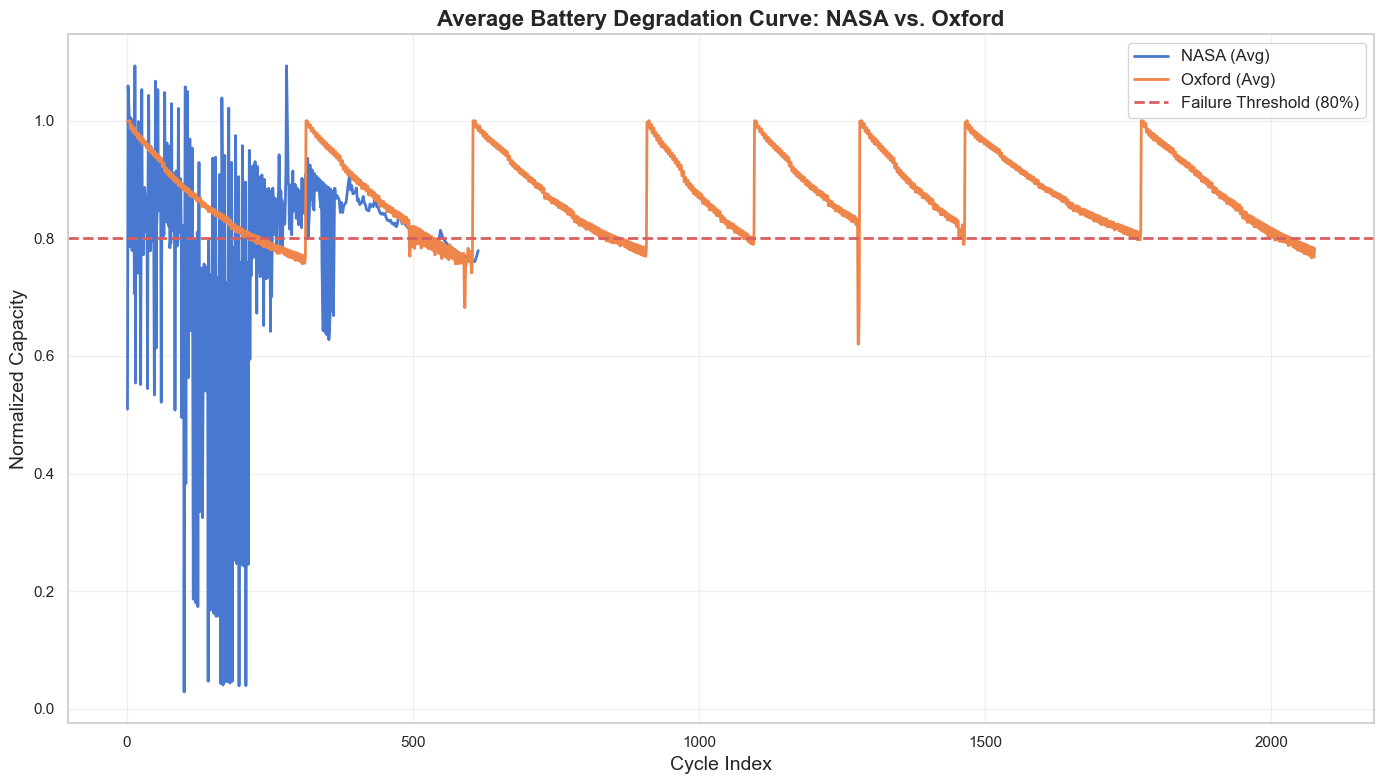

In [50]:
plt.figure(figsize=(14, 8))

# Plot average norm_capacity over cycles for each dataset
for dataset in df['dataset'].unique():
    subset = df[df['dataset'] == dataset]
    avg_curve = subset.groupby('cycle_index')['norm_capacity'].mean().reset_index()
    plt.plot(avg_curve['cycle_index'], avg_curve['norm_capacity'], label=f'{dataset} (Avg)', linewidth=2)

plt.axhline(y=0.8, color='r', linestyle='--', label='Failure Threshold (80%)', linewidth=2)
plt.xlabel('Cycle Index', fontsize=14)
plt.ylabel('Normalized Capacity', fontsize=14)
plt.title('Average Battery Degradation Curve: NASA vs. Oxford', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../plots/avg_degradation_curve.png', dpi=300, bbox_inches='tight')
plt.show()

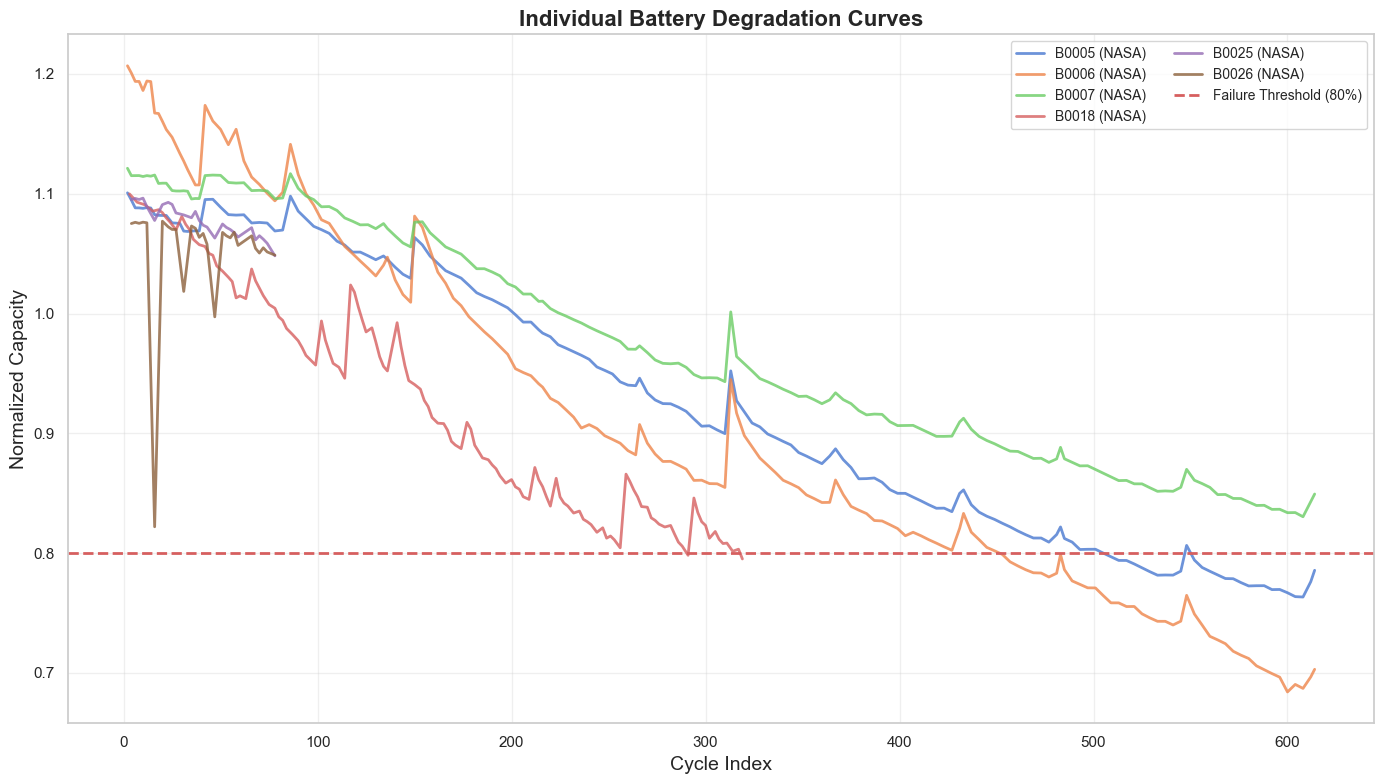

In [51]:
plt.figure(figsize=(14, 8))

# Plot a few individual curves
batteries_to_plot = df['battery_id'].unique()[:6]

for bat_id in batteries_to_plot:
    subset = df[df['battery_id'] == bat_id]
    dataset = subset['dataset'].iloc[0]
    plt.plot(subset['cycle_index'], subset['norm_capacity'], 
             label=f'{bat_id} ({dataset})', linewidth=2, alpha=0.8)

plt.axhline(y=0.8, color='r', linestyle='--', label='Failure Threshold (80%)', linewidth=2)
plt.xlabel('Cycle Index', fontsize=14)
plt.ylabel('Normalized Capacity', fontsize=14)
plt.title('Individual Battery Degradation Curves', fontsize=16, fontweight='bold')
plt.legend(fontsize=10, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../plots/individual_degradation_curves.png', dpi=300, bbox_inches='tight')
plt.show()

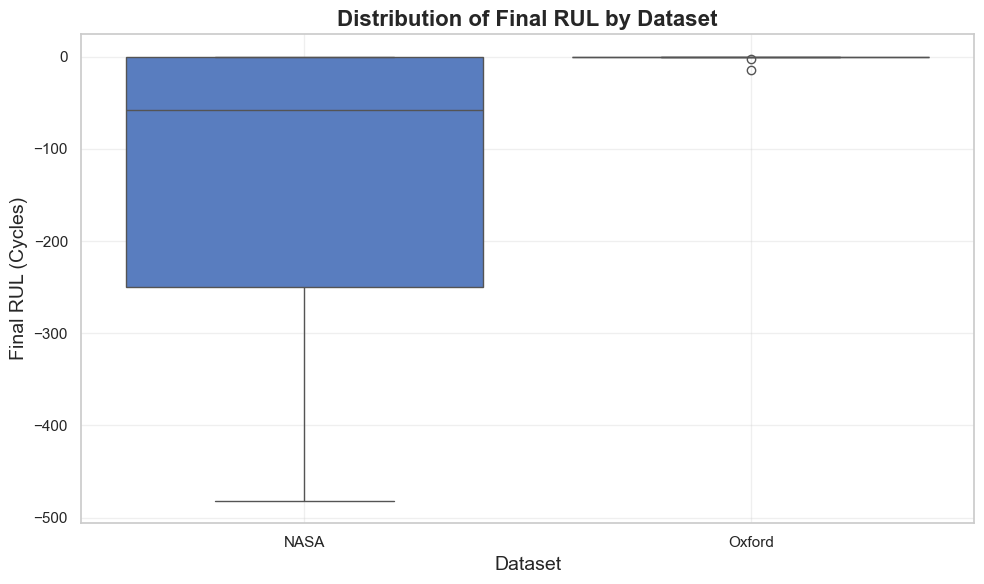

Final RUL Statistics:
         count        mean         std    min    25%   50%  75%  max
dataset                                                             
NASA      34.0 -121.617647  150.398061 -482.0 -250.0 -58.0  0.0  0.0
Oxford     8.0   -2.000000    4.898979  -14.0   -0.5   0.0  0.0  0.0


In [52]:
# Get the final RUL for each battery
final_rul = df.groupby('battery_id').tail(1)[['battery_id', 'RUL', 'dataset']]

plt.figure(figsize=(10, 6))
sns.boxplot(data=final_rul, x='dataset', y='RUL')
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Final RUL (Cycles)', fontsize=14)
plt.title('Distribution of Final RUL by Dataset', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../plots/final_rul_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Final RUL Statistics:")
print(final_rul.groupby('dataset')['RUL'].describe())

In [53]:
# Calculate the failure cycle for each battery
failure_cycles = df.groupby('battery_id').apply(
    lambda group: group[group['norm_capacity'] <= 0.7]['cycle_index'].min()
)

# If a battery never failed, use its last cycle
failure_cycles = failure_cycles.fillna(df.groupby('battery_id')['cycle_index'].max())

# The "final RUL" at the start would be this value minus 1 (since RUL at cycle 1 is failure_cycle - 1)
# But for analysis, just show the failure cycle
print("Failure Cycle Statistics:")
print(failure_cycles.describe())

Failure Cycle Statistics:
count      42.000000
mean      298.500000
std       523.346653
min         1.000000
25%         1.000000
50%        51.000000
75%       317.250000
max      2076.000000
dtype: float64


C:\Users\mufas\AppData\Local\Temp\ipykernel_22032\880276458.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  failure_cycles = df.groupby('battery_id').apply(


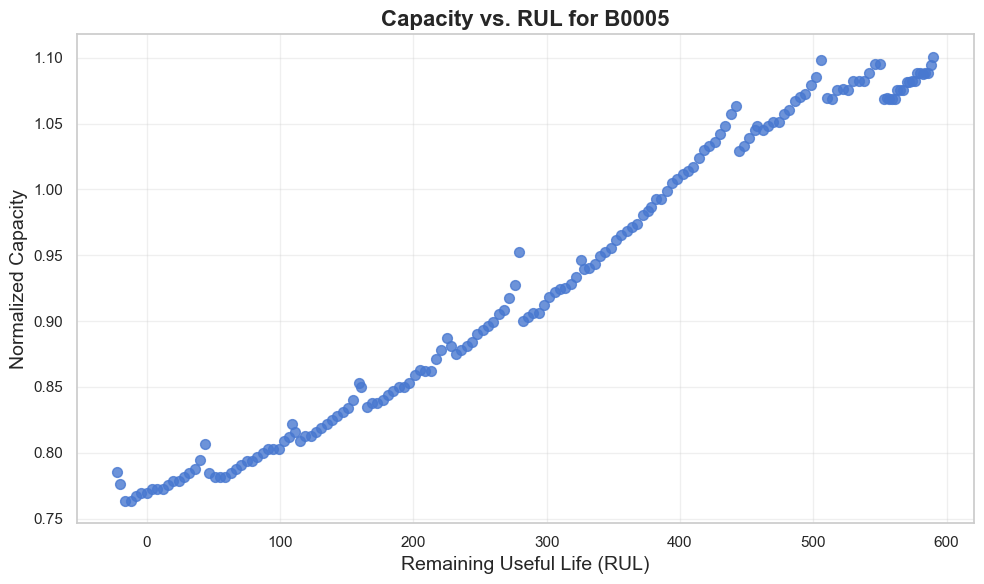

In [54]:
# Pick a battery to visualize the relationship
sample_battery = df['battery_id'].iloc[0]
subset = df[df['battery_id'] == sample_battery]

plt.figure(figsize=(10, 6))
plt.scatter(subset['RUL'], subset['norm_capacity'], alpha=0.8, s=50)
plt.xlabel('Remaining Useful Life (RUL)', fontsize=14)
plt.ylabel('Normalized Capacity', fontsize=14)
plt.title(f'Capacity vs. RUL for {sample_battery}', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../plots/capacity_vs_rul.png', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
with open('../reports/eda_summary.md', 'w') as f:
    f.write("# Battery RUL Project - EDA Summary\n\n")
    f.write("## Dataset Overview\n")
    f.write(f"- Total Records: {len(df)}\n")
    f.write(f"- NASA Batteries: {df[df['dataset']=='NASA']['battery_id'].nunique()}\n")
    f.write(f"- Oxford Batteries: {df[df['dataset']=='Oxford']['battery_id'].nunique()}\n")
    f.write(f"- Max Cycles (NASA): {df[df['dataset']=='NASA']['cycle_index'].max()}\n")
    f.write(f"- Max Cycles (Oxford): {df[df['dataset']=='Oxford']['cycle_index'].max()}\n\n")
    f.write("## Key Insights\n")
    f.write("- Oxford batteries show more variability in degradation.\n")
    f.write("- NASA batteries have a more consistent, linear degradation pattern.\n")
    f.write("- RUL prediction is a viable goal for both datasets.\n")

print("✅ EDA completed. Plots and summary saved.")

✅ EDA completed. Plots and summary saved.
